## Features+Head Starter - train

https://www.kaggle.com/code/nartaa/features-head-starter/notebook

Ensembleは行わない

### Configration

In [2]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [3]:
import os, gc

import numpy as np
import polars as pl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

TensorFlow version = 2.15.0


In [4]:
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 1 GPU


2024-03-26 00:20:13.994988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 00:20:13.999466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 00:20:13.999562: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
from src.cfg.v2 import CFG

In [6]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if CFG.MIX:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


In [7]:
TARGETS = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
META = ["spectrogram_id", "spectrogram_label_offset_seconds", "patient_id", "expert_consensus"]

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']

### Load and create Non-Overlapping eeg_id train csv

In [8]:
def add_kl(df):
    labels = df[TARGETS].values + 1e-5
    df["kl"] = tf.keras.losses.KLDivergence(reduction="none")(np.array([[1/6]*6]*len(df)), labels)

    return df

train_df = pd.read_csv(os.path.join(CFG.BASE_PATH, "train.csv"))

train_df = train_df.groupby("eeg_id")[META+TARGETS].agg({**{m: "first" for m in META}, **{t: "sum" for t in TARGETS}}).reset_index()
# TARGETSを割合とする
train_df[TARGETS] = train_df[TARGETS]/train_df[TARGETS].values.sum(axis=1, keepdims=True)
train_df.columns = ["eeg_id", "spec_id", "offset", "patient_id", "target"] + TARGETS

train_df = add_kl(train_df)

print("Train shape: ", train_df.shape)
train_df.head()

Train shape:  (17089, 12)


,eeg_id,spec_id,offset,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,kl
0,568657,789577333,0.0,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333,4.584192
1,582999,1552638400,0.0,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429,4.870032
2,642382,14960202,1008.0,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000,7.802345
3,751790,618728447,908.0,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000,7.802345
4,778705,52296320,0.0,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000,7.802345


### Load train spectrograms and eegs

In [9]:
def transform_eeg(eeg: np.ndarray) -> np.ndarray:
    rows = len(eeg)
    offset = (rows-10_000) // 2
    eeg = eeg.iloc[offset:offset+10_000]

    data = np.zeros((10_000, len(FEATS2)))
    for i, col in enumerate(FEATS2):
        # FILL NaN
        x = eeg[col].values.astype("float32")
        m = np.nanmean(x)
        if np.isnan(x).mean() < 1:
            x = np.nan_to_num(x, nan=m)
        else:
            x[:] = 0


        data[:, i] = x

    return data

In [10]:
%%time
specs = {}
eegs = {}
raw_eegs = {}
if CFG.TEST_MODE:
  train_df = train_df.sample(500, random_state=42).reset_index(drop=True)

  for i, v in enumerate(train_df["spec_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    specs[v] = pd.read_parquet(os.path.join(CFG.BASE_PATH, "train_spectrograms", f"{v}.parquet")).values

  for i, v in enumerate(train_df["eeg_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    eegs[v] = np.load(os.path.join("/kaggle/input", "brain-eeg-spectrograms", "{v}.npy"))

  for i, v in enumerate(train_df["eeg_id"].values):
    if i % 100 == 0:
      print(i, ", ", end="")
    eeg = np.load(os.path.join(CFG.BASE_PATH, "train_eegs", f"{v}.parquet"))
    raw_eegs[v] = transform_eeg(eeg)

else:
  # forを使わず一括で取得する via 公開Dataset
  specs = np.load("/kaggle/input/brain-spectrograms/specs.npy", allow_pickle=True).item()
  eegs = np.load("/kaggle/input/narata-brain-eeg-spectrograms/eeg_specs.npy", allow_pickle=True).item()
  raw_eegs = np.load("/kaggle/input/brain-eeg/eegs_processed.npy", allow_pickle=True).item()

CPU times: user 100 ms, sys: 5.15 s, total: 5.25 s
Wall time: 6.07 s


### DataLoader

In [11]:
! pip install -U albumentations

In [12]:
from src.loaders.dataloader import DataLoader

train_loader = DataLoader(
  df=train_df,
  specs=specs,
  eegs=eegs,
  augment=True,
)

In [13]:
train_loader.__getitem__(0)

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 array([0. , 0. , 0. , 0. , 0.5, 0.5], d

In [14]:
# # dataloaderのスペクトログラム画像を表示

# ROWS = 2
# COLS = 3
# BATCHES = 2

# for i, (X, y) in enumerate(train_loader):
#   plt.figure(figsize=(20,8))
#   for j in range(ROWS):
#     for k in range(COLS):
#       plt.subplot(ROWS, COLS, j*COLS+k+1)

#       img = X[j*COLS+k, :, :, 0][::-1,]

#       min_value = img.flatten().min()
#       max_value = img.flatten().max()
#       img = (img-max_value) / (max_value-min_value)

#       plt.imshow(img)

#       y_s= y[j*COLS+k]

#       y_texts = f"[{y_s[0]:0.2f}"
#       for v in y_s[1:]:
#         y_texts += f", {v:0.2f}"

#       eeg = processed_train_df["eeg_id"].values[i*32+j*COLS+k]

#       plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
#       plt.yticks([])
#       plt.ylabel("Frequencies (Hz)", size=14)
#       plt.xlabel("Time (sec)", size=16)

#   plt.show()

#   if i == (BATCHES -1):
#     break




In [15]:
del train_loader
gc.collect()

194

### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

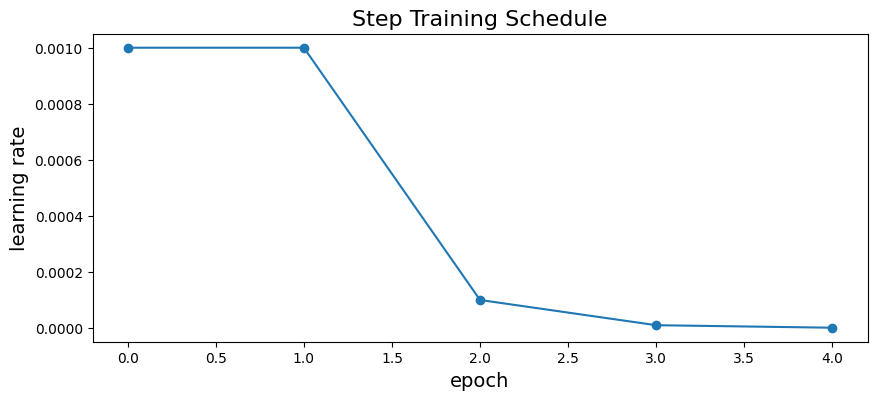

In [16]:
import math

def lrfn(epoch):
  if epoch < CFG.LR_RAMPUP_EPOCHS:
    lr = (CFG.LR_MAX - CFG.LR_START) / CFG.LR_RAMPUP_EPOCHS * epoch + CFG.LR_START
  elif epoch < (CFG.LR_RAMPUP_EPOCHS + CFG.LR_SUSTAIN_EPOCHS):
    lr = CFG.LR_MAX
  else:
    lr = CFG.LR_MAX * CFG.LR_STEP_DECAY ** ((epoch - CFG.LR_RAMPUP_EPOCHS - CFG.LR_SUSTAIN_EPOCHS) // CFG.EVERY)

  return lr

rng = [i for i in range(CFG.EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

def lrfn2(epoch):
  return [1e-5, 1e-5, 1e-6][epoch]

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose=True)

In [19]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


### Transfer Learning

In [21]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

from src.models.efficientnet_b0 import EfficientNetB0

losses = []
val_losses = []
total_hist = {}
all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(gkf.split(train_df, train_df["target"], train_df["patient_id"])):
  print(f"Fold {i+1}")

  inp = tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32)
  output_signature = (inp, tf.TensorSpec(shape=(6,), dtype=tf.float32))

  transfer_train_df = train_df.iloc[train_ix]

  train_loader = DataLoader(
    df=transfer_train_df,
    specs=specs,
    eegs=eegs,
    augment=True,
  )
  train_dataset = tf.data.Dataset.from_generator(generator=train_loader, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  valid_loader = DataLoader(
    df=train_df.iloc[valid_ix],
    specs=specs,
    eegs=eegs,
    augment=False,
    mode="valid",
  )
  valid_dataset = tf.data.Dataset.from_generator(generator=valid_loader, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  # transfer learning
  transfer_train_df = transfer_train_df[transfer_train_df["kl"] < 5.5]

  train_loader2 = DataLoader(
    df=transfer_train_df,
    specs=specs,
    eegs=eegs,
    augment=True,
  )
  train_dataset2 = tf.data.Dataset.from_generator(generator=train_loader2, output_signature=output_signature).batch(CFG.BATCH_SIZE)

  K.clear_session()

  with strategy.scope():
    model = EfficientNetB0.build_model()

  if CFG.LOAD_MODELS_FROM_TRAIN == "":
    print(f"first stage train size {3*len(train_ix)}, valid size {3*len(valid_ix)}")
    history = model.fit(
      train_dataset,
      verbose=1,
      validation_data=valid_dataset,
      epochs=CFG.EPOCHS,
      callbacks=[LR],
    )

    print(f"second stage train size {3*len(transfer_train_df)}, valid size {3*len(valid_ix)}")
    history2 = model.fit(
      train_dataset2,
      verbose=1,
      validation_data=valid_dataset,
      epochs=CFG.EPOCHS2,
      callbacks=[LR2],
    )

    losses.append(history.history["loss"] + history2.history["loss"])
    val_losses.append(history.history["val_loss"] + history2.history["val_loss"])

    model.save_weights(f"/kaggle/output/EfficientNet_v{CFG.VER}_f{i}.weights.h5")
  else:
    model.load_weights(f"{CFG.LOAD_MODELS_FROM_TRAIN}/Efficient_v{CFG.VER}_f{i}.weights.h5")

  pred = model.predict(valid_dataset, verbose=1)
  pred = (pred[:len(valid_ix)] + pred[len(valid_ix): len(valid_ix)*2] + pred[len(valid_ix)*2:])/3

  oof = pred

  all_oof.append(oof)
  all_true.append(train_df.iloc[valid_ix][TARGETS].values)

  del model, oof
  gc.collect()

total_hist["loss"] = np.mean(losses, axis=0)
total_hist["val_loss"] = np.mean(val_losses, axis=0)
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

Fold 1
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-26 04:11:29.394738: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-26 04:11:33.805720: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 616/12046 nodes to float16 precision using 132 cast(s) to float16 (excluding Const and Variable casts)


   1282/Unknown 438s 331ms/step - loss: 0.7821

2024-03-26 04:18:40.973656: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:18:40.973686: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:18:40.973692: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:18:40.973696: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:18:40.973701: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:18:40.973705: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:18:40.973709: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 459s 348ms/step - loss: 0.7820 - val_loss: 1.2982 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.5468

2024-03-26 04:26:07.147621: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:26:07.147634: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:26:07.147637: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:26:07.147639: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:26:07.147641: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:26:07.147642: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:26:07.147644: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 451s 351ms/step - loss: 0.5468 - val_loss: 1.0858 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.4252

2024-03-26 04:33:37.649414: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:33:37.649431: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:33:37.649434: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:33:37.649436: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:33:37.649437: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:33:37.649439: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:33:37.649441: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 349ms/step - loss: 0.4252 - val_loss: 0.8431 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3665

2024-03-26 04:41:05.553323: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:41:05.553343: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:41:05.553346: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:41:05.553347: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:41:05.553349: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:41:05.553351: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:41:05.553353: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 446s 348ms/step - loss: 0.3665 - val_loss: 0.8381 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3607

2024-03-26 04:48:31.766935: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:48:31.766956: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:48:31.766962: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:48:31.766966: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:48:31.766971: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:48:31.766975: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:48:31.766979: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 447s 348ms/step - loss: 0.3607 - val_loss: 0.8434 - learning_rate: 1.0000e-06
second stage train size 8475, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    265/Unknown 88s 331ms/step - loss: 0.4417

2024-03-26 04:50:22.046373: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:50:22.046393: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:50:22.046399: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:50:22.046403: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:50:22.046408: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:50:22.046412: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:50:22.046416: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

265/265 ━━━━━━━━━━━━━━━━━━━━ 113s 428ms/step - loss: 0.4416 - val_loss: 0.7964 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3469

2024-03-26 04:52:15.521791: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:52:15.521811: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:52:15.521817: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:52:15.521821: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:52:15.521826: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:52:15.521830: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:52:15.521834: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

265/265 ━━━━━━━━━━━━━━━━━━━━ 112s 423ms/step - loss: 0.3469 - val_loss: 0.7643 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3257

2024-03-26 04:54:07.656291: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 04:54:07.656315: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 04:54:07.656321: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 04:54:07.656325: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 04:54:07.656330: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 04:54:07.656334: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 04:54:07.656338: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

265/265 ━━━━━━━━━━━━━━━━━━━━ 111s 417ms/step - loss: 0.3257 - val_loss: 0.7653 - learning_rate: 1.0000e-06


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 04:54:31.380693: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1516 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


    320/Unknown 16s 48ms/step

2024-03-26 04:54:47.542928: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1567 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Fold 2
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-26 04:54:54.909819: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-26 04:54:59.862239: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 616/12046 nodes to float16 precision using 132 cast(s) to float16 (excluding Const and Variable casts)


   1282/Unknown 438s 331ms/step - loss: 0.7904

2024-03-26 05:02:06.952684: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:02:06.952720: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:02:06.952722: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:02:06.952724: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:02:06.952726: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:02:06.952727: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:02:06.952729: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 460s 349ms/step - loss: 0.7903 - val_loss: 0.8865 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.5507

2024-03-26 05:09:34.286292: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:09:34.286311: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:09:34.286313: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:09:34.286315: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:09:34.286317: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:09:34.286319: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:09:34.286320: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 451s 351ms/step - loss: 0.5507 - val_loss: 0.8575 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.4380

2024-03-26 05:17:05.063112: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:17:05.063136: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:17:05.063142: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:17:05.063146: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:17:05.063151: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:17:05.063155: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 5337285635615247464
2024-03-26 05:17:05.063160: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 447s 348ms/step - loss: 0.4380 - val_loss: 0.7101 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3719

2024-03-26 05:24:31.812746: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:24:31.812769: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:24:31.812775: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:24:31.812779: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:24:31.812784: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:24:31.812788: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:24:31.812792: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 349ms/step - loss: 0.3719 - val_loss: 0.7494 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3618

2024-03-26 05:31:59.697697: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 05:31:59.697738: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:31:59.697741: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:31:59.697743: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:31:59.697744: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:31:59.697746: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:31:59.697748: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 450s 351ms/step - loss: 0.3618 - val_loss: 0.7519 - learning_rate: 1.0000e-06
second stage train size 8880, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    278/Unknown 93s 335ms/step - loss: 0.4249

2024-03-26 05:33:58.328051: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 05:33:58.328067: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 05:33:58.328070: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:33:58.328072: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:33:58.328073: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:33:58.328075: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:33:58.328077: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

278/278 ━━━━━━━━━━━━━━━━━━━━ 117s 422ms/step - loss: 0.4248 - val_loss: 0.7303 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3341

2024-03-26 05:35:54.511609: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:35:54.511624: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:35:54.511626: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:35:54.511628: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:35:54.511630: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:35:54.511632: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:35:54.511633: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

278/278 ━━━━━━━━━━━━━━━━━━━━ 116s 416ms/step - loss: 0.3341 - val_loss: 0.7174 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3132

2024-03-26 05:37:50.111132: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:37:50.111160: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:37:50.111166: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:37:50.111170: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:37:50.111175: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7805667830095877860
2024-03-26 05:37:50.111179: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 05:37:50.111183: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

278/278 ━━━━━━━━━━━━━━━━━━━━ 117s 420ms/step - loss: 0.3132 - val_loss: 0.7185 - learning_rate: 1.0000e-06


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 05:38:15.593605: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1516 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


    320/Unknown 19s 56ms/step

2024-03-26 05:38:34.122116: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1567 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


321/321 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Fold 3
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-26 05:38:42.086564: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-26 05:38:46.991577: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 616/12046 nodes to float16 precision using 132 cast(s) to float16 (excluding Const and Variable casts)


   1282/Unknown 437s 331ms/step - loss: 0.7697

2024-03-26 05:45:53.623161: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 05:45:53.623187: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 05:45:53.623189: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:45:53.623191: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:45:53.623193: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:45:53.623195: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:45:53.623196: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 463s 351ms/step - loss: 0.7696 - val_loss: 0.8474 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.5453

2024-03-26 05:53:24.078119: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 05:53:24.078139: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 05:53:24.078142: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 05:53:24.078144: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 05:53:24.078145: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 05:53:24.078147: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 05:53:24.078149: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 447s 348ms/step - loss: 0.5453 - val_loss: 0.9236 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.4233

2024-03-26 06:00:50.818339: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:00:50.818363: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:00:50.818369: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 06:00:50.818373: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:00:50.818377: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:00:50.818382: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:00:50.818386: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 349ms/step - loss: 0.4233 - val_loss: 0.7129 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3624

2024-03-26 06:08:18.657217: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:08:18.657234: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:08:18.657236: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:08:18.657238: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:08:18.657240: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:08:18.657242: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 06:08:18.657243: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 350ms/step - loss: 0.3624 - val_loss: 0.7196 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3591

2024-03-26 06:15:47.027931: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:15:47.027948: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:15:47.027951: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:15:47.027953: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:15:47.027955: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:15:47.027956: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17362053220337535862
2024-03-26 06:15:47.027958: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 350ms/step - loss: 0.3591 - val_loss: 0.7214 - learning_rate: 1.0000e-06
second stage train size 9135, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    286/Unknown 96s 335ms/step - loss: 0.4053

2024-03-26 06:17:47.016262: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:17:47.016286: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:17:47.016292: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 06:17:47.016296: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:17:47.016301: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:17:47.016305: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:17:47.016309: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

286/286 ━━━━━━━━━━━━━━━━━━━━ 119s 417ms/step - loss: 0.4052 - val_loss: 0.7129 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3149

2024-03-26 06:19:45.083613: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:19:45.083633: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:19:45.083639: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 06:19:45.083644: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:19:45.083648: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:19:45.083652: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:19:45.083657: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

286/286 ━━━━━━━━━━━━━━━━━━━━ 119s 416ms/step - loss: 0.3149 - val_loss: 0.7015 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3148

2024-03-26 06:21:44.131146: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11970931786780864698
2024-03-26 06:21:44.131166: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6660933384647918476
2024-03-26 06:21:44.131169: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10724142386347611166
2024-03-26 06:21:44.131171: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10267981648259618278
2024-03-26 06:21:44.131172: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4431864418557478486
2024-03-26 06:21:44.131174: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13451262632196499166
2024-03-26 06:21:44.131176: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send

286/286 ━━━━━━━━━━━━━━━━━━━━ 119s 416ms/step - loss: 0.3148 - val_loss: 0.7081 - learning_rate: 1.0000e-06


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 06:22:09.448012: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1516 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


    320/Unknown 18s 54ms/step

2024-03-26 06:22:27.457277: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1567 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


321/321 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Fold 4
first stage train size 41013, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-26 06:22:35.346125: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-26 06:22:40.245104: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 616/12046 nodes to float16 precision using 132 cast(s) to float16 (excluding Const and Variable casts)


   1282/Unknown 436s 330ms/step - loss: 0.7727

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 06:29:46.473499: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1604 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 460s 349ms/step - loss: 0.7726 - val_loss: 0.8253 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.5409

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 446s 348ms/step - loss: 0.5409 - val_loss: 0.9525 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.4126

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 349ms/step - loss: 0.4126 - val_loss: 0.6611 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3507

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 446s 348ms/step - loss: 0.3507 - val_loss: 0.7038 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.3485

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 445s 347ms/step - loss: 0.3485 - val_loss: 0.7004 - learning_rate: 1.0000e-06
second stage train size 8874, valid size 10254

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    278/Unknown 93s 333ms/step - loss: 0.4205

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 114s 409ms/step - loss: 0.4203 - val_loss: 0.6873 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.3241

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 118s 423ms/step - loss: 0.3241 - val_loss: 0.6800 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.3043

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 116s 417ms/step - loss: 0.3043 - val_loss: 0.6821 - learning_rate: 1.0000e-06


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 07:05:43.622500: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1516 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


    319/Unknown 18s 54ms/step

2024-03-26 07:06:01.564244: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1567 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


321/321 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Fold 5
first stage train size 41016, valid size 10251

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-26 07:06:09.624019: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-26 07:06:14.559564: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 616/12046 nodes to float16 precision using 132 cast(s) to float16 (excluding Const and Variable casts)


   1282/Unknown 439s 332ms/step - loss: 0.7902

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 07:13:23.477000: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1604 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 463s 351ms/step - loss: 0.7901 - val_loss: 0.8096 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.5497

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 444s 346ms/step - loss: 0.5497 - val_loss: 0.8430 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.4291

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 448s 350ms/step - loss: 0.4291 - val_loss: 0.6414 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3691

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 449s 350ms/step - loss: 0.3691 - val_loss: 0.6689 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0000000000000002e-06.
Epoch 5/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3587

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 449s 350ms/step - loss: 0.3587 - val_loss: 0.6738 - learning_rate: 1.0000e-06
second stage train size 8892, valid size 10251

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


    278/Unknown 94s 339ms/step - loss: 0.4325

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 118s 424ms/step - loss: 0.4323 - val_loss: 0.6654 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3443

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 118s 425ms/step - loss: 0.3443 - val_loss: 0.6642 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3157

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


278/278 ━━━━━━━━━━━━━━━━━━━━ 116s 415ms/step - loss: 0.3157 - val_loss: 0.6652 - learning_rate: 1.0000e-06


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-26 07:49:30.181753: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1516 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


    320/Unknown 16s 48ms/step

2024-03-26 07:49:46.232262: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 395/1567 nodes to float16 precision using 114 cast(s) to float16 (excluding Const and Variable casts)


321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### CV score for EfficientNet

KL(=Kullback-Leibler) Divergenceによる性能評価
https://qiita.com/shuva/items/81ad2a337175c035988f

In [22]:
from src.metrics import kl_div

oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

cv = kl_div.score(solution=true, submission=oof, row_id_column_name="id")

print("CV score KL-Div for EfficientNetB0=", cv)

CV score KL-Div for EfficientNetB0= 0.6299680938303995


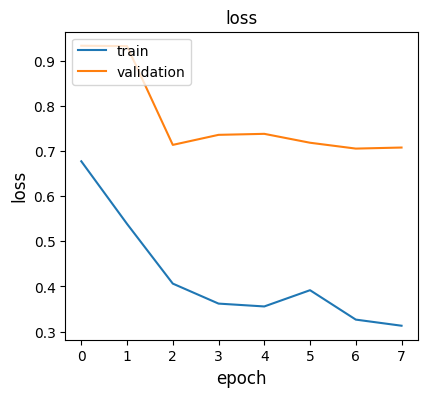

In [23]:
def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

plot_hist(total_hist)

### Local Ensembel Testing on CV